In [ ]:
import pandas as pd

CSV_PATH = "../data/raw/complaints.csv"
REQUIRED_COLUMNS = [
    "Product",
    "Consumer complaint narrative",
    "Complaint ID",
    "Issue",
 ]

try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError as e:
    raise FileNotFoundError(f"Raw complaints file not found at {CSV_PATH}") from e
except pd.errors.EmptyDataError as e:
    raise ValueError("Raw complaints file is empty") from e
except Exception as e:
    raise RuntimeError(f"Failed to load complaints CSV: {e}") from e

missing_cols = [col for col in REQUIRED_COLUMNS if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print(df.shape)
print(df.columns)
print(df.head())


C:\Users\weldi\AppData\Local\Temp\ipykernel_22232\1794118956.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/complaints.csv")


(9609797, 18)
Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')
  Date received                                            Product  \
0    2025-06-20  Credit reporting or other personal consumer re...   
1    2025-06-20                                    Debt collection   
2    2025-06-20  Credit reporting or other personal consumer re...   
3    2025-06-20  Credit reporting or other personal consumer re...   
4    2025-06-20  Credit reporting or other personal consumer re...   

               Sub-product                                 Issue  \
0         Credit reporting  Incorrect information on your report   
1  Telecommunications debt     Attempts to col

Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
Vehicle loan or lease   

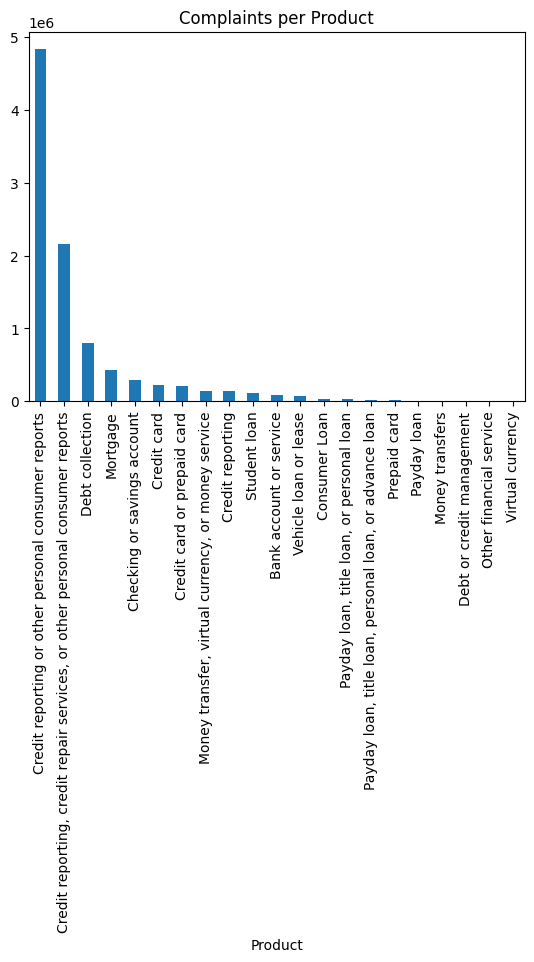

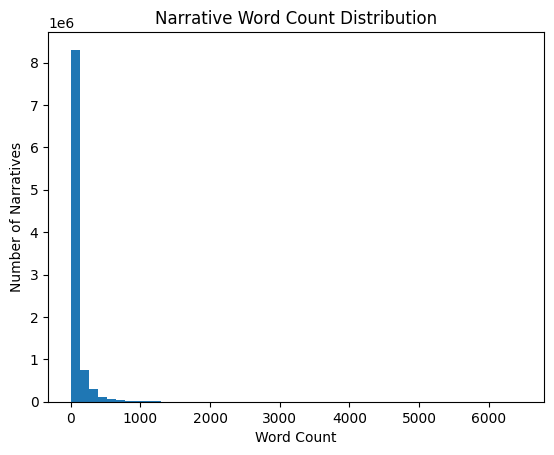

Missing narratives: 6629041
Filtered dataset shape: (80667, 20)
✅ Filtered and cleaned dataset saved successfully!


In [7]:
import pandas as pd
import re
import matplotlib.pyplot as plt


# 1 Initial EDA: Product distribution
product_counts = df['Product'].value_counts()
print(product_counts)
product_counts.plot(kind='bar', title='Complaints per Product')
plt.show()

# 3 Narrative length: word count
df['narrative_word_count'] = df['Consumer complaint narrative'].astype(str).apply(lambda x: len(x.split()))
plt.hist(df['narrative_word_count'], bins=50)
plt.title('Narrative Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Number of Narratives')
plt.show()

# Count missing narratives
missing_narratives = df['Consumer complaint narrative'].isna().sum()
print(f"Missing narratives: {missing_narratives}")

# 4️⃣ Filter dataset for 5 specified products
products = ['Credit card', 'Personal loan', 'Savings account', 'Money transfer', 'Checking account']  # Added missing 5th product
df_filtered = df[df['Product'].isin(products)]
df_filtered = df_filtered.dropna(subset=['Consumer complaint narrative'])
print(f"Filtered dataset shape: {df_filtered.shape}")

# 5️⃣ Cleaning function with optional boilerplate removal
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-z0-9,.!? ]', '', text)
    boilerplate_patterns = [
        r'i am writing to file a complaint', 
        r'please investigate this matter',
        r'this is a complaint about'
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text)
    text = text.strip()
    return text

df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_text)

# 6️⃣ Save processed dataset
df_filtered.to_csv("../data/processed/filtered_complaints.csv", index=False)
print("✅ Filtered and cleaned dataset saved successfully!")


In [ ]:
import re

products = ['Credit card', 'Personal loan', 'Savings account', 'Money transfer']
df_filtered = df[df['Product'].isin(products)]

if df_filtered.empty:
    raise ValueError("No rows remaining after filtering for selected products.")

df_filtered = df_filtered.dropna(subset=['Consumer complaint narrative'])
if df_filtered.empty:
    raise ValueError("No narratives available after dropping missing values.")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-z0-9,.!? ]', '', text)
    return text

df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_text)

df_filtered.to_csv("../data/processed/filtered_complaints.csv", index=False)
print("Filtered dataset saved.")


Filtered dataset saved.


In [ ]:
import math

sample_size = 15000
if df_filtered.empty:
    raise ValueError("Cannot sample because the filtered dataframe is empty.")

# Cap sample size to the available rows to avoid ValueError when sample_size > len(df_filtered)
effective_sample_size = min(sample_size, len(df_filtered))
sample_fraction = effective_sample_size / len(df_filtered)

df_sample = df_filtered.groupby('Product', group_keys=False).apply(
    lambda x: x.sample(frac=sample_fraction, random_state=42)
)

if df_sample.empty:
    raise ValueError("Sampling produced an empty dataframe; check filtering and sample_size.")

df_sample.to_csv("../data/processed/sample_complaints.csv", index=False)
print(f"Sampled dataset saved with {len(df_sample)} rows.")


C:\Users\weldi\AppData\Local\Temp\ipykernel_22232\1172563365.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_filtered.groupby('Product', group_keys=False).apply(


Sampled dataset saved.


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pandas as pd

if df_sample.empty:
    raise ValueError("Chunking skipped because df_sample is empty.")

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

all_chunks = []
for _, row in df_sample.iterrows():
    text_value = row.get('cleaned_narrative')
    if not isinstance(text_value, str) or not text_value.strip():
        continue  # skip rows without usable text
    chunks = splitter.split_text(text_value)
    for i, chunk in enumerate(chunks):
        all_chunks.append({
            'complaint_id': row['Complaint ID'],
            'product': row['Product'],
            'issue': row['Issue'],
            'chunk_index': i,
            'text': chunk
        })

df_chunks = pd.DataFrame(all_chunks)
if df_chunks.empty:
    raise ValueError("No chunks were created; verify the splitter and input text.")

df_chunks.to_csv("../data/processed/chunks.csv", index=False)
print(f"Total chunks created: {len(df_chunks)}")



Total chunks created: 42911


In [6]:
import uuid
import pandas as pd
from sentence_transformers import SentenceTransformer
import chromadb

if df_chunks.empty:
    raise ValueError("Vector store build aborted because df_chunks is empty.")

try:
    model = SentenceTransformer("all-MiniLM-L6-v2")
except Exception as e:
    raise RuntimeError(f"Failed to load embedding model: {e}") from e

try:
    client = chromadb.PersistentClient(path="../vector_store")
    collection = client.get_or_create_collection(name="complaints")
except Exception as e:
    raise RuntimeError(f"Failed to initialize ChromaDB: {e}") from e

BATCH_SIZE = 128
all_texts = df_chunks["text"].tolist()
all_metadatas = df_chunks[["complaint_id", "product", "issue"]].to_dict('records')
all_ids = [str(uuid.uuid4()) for _ in range(len(df_chunks))]

if not all_texts:
    raise ValueError("No texts available for embedding and storage.")

print(f"Starting batch processing for {len(all_texts)} chunks...")

for i in range(0, len(all_texts), BATCH_SIZE):
    batch_texts = all_texts[i : i + BATCH_SIZE]
    batch_metadatas = all_metadatas[i : i + BATCH_SIZE]
    batch_ids = all_ids[i : i + BATCH_SIZE]
    
    try:
        batch_embeddings = model.encode(batch_texts, show_progress_bar=False).tolist()
    except Exception as e:
        raise RuntimeError(f"Embedding batch starting at index {i} failed: {e}") from e
    
    try:
        collection.add(
            documents=batch_texts,
            embeddings=batch_embeddings,
            metadatas=batch_metadatas,
            ids=batch_ids
        )
    except Exception as e:
        raise RuntimeError(f"ChromaDB add failed for batch starting at index {i}: {e}") from e
    
    if i % (BATCH_SIZE * 5) == 0:
        print(f"Processed {i + len(batch_texts)} / {len(all_texts)} chunks...")

print("✅ Vector store saved successfully with batching!")

Starting batch processing for 42911 chunks...
Processed 128 / 42911 chunks...
Processed 768 / 42911 chunks...
Processed 1408 / 42911 chunks...
Processed 2048 / 42911 chunks...
Processed 2688 / 42911 chunks...
Processed 3328 / 42911 chunks...
Processed 3968 / 42911 chunks...
Processed 4608 / 42911 chunks...
Processed 5248 / 42911 chunks...
Processed 5888 / 42911 chunks...
Processed 6528 / 42911 chunks...
Processed 7168 / 42911 chunks...
Processed 7808 / 42911 chunks...
Processed 8448 / 42911 chunks...
Processed 9088 / 42911 chunks...
Processed 9728 / 42911 chunks...
Processed 10368 / 42911 chunks...
Processed 11008 / 42911 chunks...
Processed 11648 / 42911 chunks...
Processed 12288 / 42911 chunks...
Processed 12928 / 42911 chunks...
Processed 13568 / 42911 chunks...
Processed 14208 / 42911 chunks...
Processed 14848 / 42911 chunks...
Processed 15488 / 42911 chunks...
Processed 16128 / 42911 chunks...
Processed 16768 / 42911 chunks...
Processed 17408 / 42911 chunks...
Processed 18048 / 42